In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau  # used in pretrain loop
from torchvision.transforms import v2 as T
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

# Local modules (dataset, samplers, losses, model)
from ShroomDataset import (
    ShroomDataset, HierSupConLoss, ContrastiveWrapper,
    TwoCropsTransform, HierBatchSampler
)
from ShroomCNN import ShroomCNNAttentive, AuxSpeciesHead

# Metrics & utilities
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, top_k_accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from PIL import Image, ImageOps
import os
from tqdm.auto import tqdm
from contextlib import nullcontext

data_path = './data/'

train_meta = pd.read_csv(os.path.join(data_path, 'train.csv'))#.iloc[:1000]
val_meta = pd.read_csv(os.path.join(data_path, 'val.csv'))
test_meta = pd.read_csv(os.path.join(data_path, 'test.csv'))

In [ ]:
IMGc = 172 # lower for pretraining
# default imagenet
mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)

# transforms for view
heavy_geom = T.Compose([
    T.RandomResizedCrop(IMGc, scale=(0.65, 1.0), ratio=(0.80, 1.25), antialias=False),
    T.RandomAffine(degrees=7, translate=(0.05, 0.05), scale=(0.97, 1.03)),
])

light_view = T.Compose([
    T.RandomHorizontalFlip(0.5),
    T.RandomVerticalFlip(0.1),
    T.RandomApply([T.ColorJitter(0.15, 0.15, 0.15, 0.04)], p=0.4),
    T.RandomGrayscale(p=0.08),
    T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.05),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean, std),
])



In [ ]:
# base dataset
cont_base = ShroomDataset(train_meta, data_path, transform=None, cache=False)
# contrastive dataset
cont_ds   = ContrastiveWrapper(cont_base, TwoCropsTransform(heavy_geom, light_view))

# for sampling
num_classes = len(cont_ds.base.label2idx)
train_labels = np.asarray(cont_ds.base.labels, dtype=np.int64)
idx2label = {v: k for k,v in cont_ds.base.label2idx.items()}
# frequency-based weights (inverse freq)
counts = np.bincount(train_labels, minlength=num_classes)
# alpha is the smoothing factor
alpha = 0.5  # try 0.3–0.7
class_w = (np.maximum(counts, 1) ** -alpha)
sample_w = class_w[train_labels]

# Build a consistent mapping: species_id -> genus_id
species_names = list(cont_ds.base.label2idx.keys())          # unique species names
genus2idx = {g:i for i,g in enumerate(sorted({s.split()[0] for s in species_names}))}

num_species = len(species_names)
species_to_genus = torch.empty(num_species, dtype=torch.long)
for sp_name, sp_id in cont_ds.base.label2idx.items():
    g_id = genus2idx[sp_name.split()[0]]
    species_to_genus[sp_id] = g_id

per_sample_genus = np.asarray([int(species_to_genus[sp]) for sp in cont_ds.base.labels],
                              dtype=np.int64)
NUM_WORKERS = min(8, max(1, (os.cpu_count() or 4) // 2))
print(f"Using {NUM_WORKERS} workers")

# Build the base hierarchical sampler
hb_sampler = HierBatchSampler(
    cont_ds.base.labels,
    per_sample_genus,
    n_genus=24, species_per_genus=3, imgs_per_species=2,
    steps=1500
)

dl_kwargs = dict(
    batch_sampler=hb_sampler,
    num_workers=NUM_WORKERS,
    persistent_workers=(NUM_WORKERS > 0),
    pin_memory=torch.cuda.is_available(),
)
if NUM_WORKERS > 0:
    dl_kwargs["prefetch_factor"] = 2  

cont_loader = DataLoader(cont_ds, **dl_kwargs)

Using 6 workers


In [ ]:
class EncoderFromBackbone(nn.Module):
    """
    Thin wrapper that:
    - runs the convolutional backbone (stem -> body -> global_pool)
    - flattens and (optionally) applies a BN on the feature vector
    The output feature dim is inferred from the backbone (feat_dim or first Linear).
    """
    def __init__(self, backbone: nn.Module, feat_bn: bool = True):
        super().__init__()
        self.stem = getattr(backbone, 'stem', nn.Identity())
        self.body = backbone.model
        self.pool = backbone.global_pool
        self.flatten = nn.Flatten()

        # prefer feature dim provided by backbone; fallback to first Linear in classifier.
        out_dim = getattr(backbone, 'feat_dim', None)
        if out_dim is None:
            first_linear = None
            for m in getattr(backbone, 'classifier', []):
                if isinstance(m, nn.Linear):
                    first_linear = m
                    break
            assert first_linear is not None, "Couldn't infer feature dim: set backbone.feat_dim or start classifier with a Linear."
            out_dim = first_linear.in_features

        self.out_dim = int(out_dim)
        self.bn = nn.BatchNorm1d(self.out_dim) if feat_bn else nn.Identity()

    def forward(self, x):
        x = self.stem(x)
        x = self.body(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = x.contiguous()
        x = self.bn(x)
        return x

class ProjectionMLP(nn.Module):
    """
    Two-layer projection head (MLP)
    """

    def __init__(self, in_dim, hid=512, out_dim=256, use_bn=True):
        super().__init__()
        layers = [nn.Linear(in_dim, hid)]
        if use_bn:
            layers.append(nn.BatchNorm1d(hid))
        layers += [nn.ReLU(inplace=True), nn.Linear(hid, out_dim)]
        # final BN without affine keeps scale/shift inside normalize
        if use_bn:
            layers.append(nn.BatchNorm1d(out_dim, affine=False))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.contiguous()
        x = self.net(x)
        return F.normalize(x, dim=1, eps=1e-8)


In [ ]:
class SupConLoss(nn.Module):
    """
    DEPRECATED, DO NOT USE, use hier sup con loss
    """
    def __init__(self, temperature=0.07):
        super().__init__()
        self.t = float(temperature)

    def forward(self, z, y):
        device = z.device
        B, V, D = z.shape

    
        if z.dtype != torch.float32:
            z = z.float()

        z = z.reshape(B * V, D).contiguous()

        # similarities / temperature
        logits = torch.matmul(z, z.T) / self.t
        logits = torch.nan_to_num(logits, nan=0.0, posinf=1e4, neginf=-1e4)

        # mask self and stabilize
        self_mask = torch.eye(B * V, device=device, dtype=torch.bool)
        logits = logits.masked_fill(self_mask, float("-inf"))

        # subtract per-row max (guard rows that are all -inf)
        row_max = logits.max(dim=1, keepdim=True).values
        row_max = torch.where(torch.isfinite(row_max), row_max, torch.zeros_like(row_max))
        logits = logits - row_max
        logits = torch.nan_to_num(logits, nan=0.0, posinf=1e4, neginf=-1e4)

        # positives mask across views
        y = y.reshape(B, 1)
        pos = (y == y.T)
        pos = pos.repeat_interleave(V, 0).repeat_interleave(V, 1)
        pos = pos & (~self_mask)

        # log softmax over rows
        log_denom = torch.logsumexp(logits, dim=1, keepdim=True)
        log_denom = torch.where(torch.isfinite(log_denom), log_denom, torch.zeros_like(log_denom))
        log_prob = logits - log_denom

        pos_counts = pos.sum(dim=1)                    # [2B]
        safe_pos = pos_counts.clamp(min=1).to(logits.dtype)
        loss = -(pos.to(logits.dtype) * log_prob).sum(dim=1) / safe_pos

        valid = (pos_counts > 0).to(logits.dtype)
        denom = valid.sum().clamp(min=1)
        out = (loss * valid).sum() / denom

        # final guard
        if not torch.isfinite(out):
            out = torch.nan_to_num(out, nan=0.0, posinf=1e4, neginf=-1e4)
        return out

In [ ]:
def get_device():
    return 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def _bn_to_fp32(m: nn.Module):
    # Force BN to compute in float32 (safer on MPS/AMP)
    if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.float()
        # slightly bigger eps helps with tiny-variance batches
        if getattr(m, "eps", None) is not None:
            m.eps = max(m.eps, 1e-5)

def pretrain_contrastive(build_backbone_fn,
                         cont_loader,
                         epochs=15,
                         lr=5e-4,
                         weight_decay=1e-4,
                         temperature=0.07,
                         use_hier=False,
                         gamma=0.3,
                         species_to_genus=None,      # only used if use_hier=True
                         aux_lambda=0.1,             # 0.05–0.2 
                         aux_detach=False,           # False recommended
                         class_weights=None):
    device = get_device()
    print(f"[SupCon pretrain] device={device}")

    #  perf knobs 
    if device == "cuda":
        torch.backends.cudnn.benchmark = True
        try:
            torch.set_float32_matmul_precision("high")
        except Exception:
            pass

    #  encoder + projector 
    backbone = build_backbone_fn()
    encoder  = EncoderFromBackbone(backbone).to(device)
    # switch module to channels-last (helps conv kernels)
    try:
        encoder = encoder.to(memory_format=torch.channels_last)
    except Exception:
        pass

    projector = ProjectionMLP(encoder.out_dim).to(device)
    aux = AuxSpeciesHead(encoder.out_dim, num_classes=len(cont_ds.base.label2idx)).to(device)

    # BN math in fp32
    encoder.apply(_bn_to_fp32)
    projector.apply(_bn_to_fp32)
    aux.apply(_bn_to_fp32)

    #  losses 
    if use_hier:
        assert species_to_genus is not None, "Provide species_to_genus (species-id -> genus-id)"
        criterion = HierSupConLoss(temperature=temperature, gamma=gamma).to(device)
        s2g_dev = species_to_genus.to(device)
    else:
        criterion = SupConLoss(temperature=temperature).to(device)

    ce_weight = None
    if class_weights is not None:
        ce_weight = torch.tensor(class_weights, dtype=torch.float32, device=device)
    aux_crit = nn.CrossEntropyLoss(weight=ce_weight, label_smoothing=0.1)

    #  build AdamW param groups: no weight decay on norm layers & biases 
    def _param_groups(module: nn.Module, wd: float):
        decay, no_decay = [], []
        for m in module.modules():
            for name, p in m.named_parameters(recurse=False):
                if not p.requires_grad: 
                    continue
                if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.GroupNorm, nn.LayerNorm)) or name.endswith("bias"):
                    no_decay.append(p)
                else:
                    decay.append(p)
        groups = []
        if decay:
            groups.append({"params": decay, "weight_decay": wd})
        if no_decay:
            groups.append({"params": no_decay, "weight_decay": 0.0})
        return groups

    param_groups = []
    param_groups += _param_groups(encoder, weight_decay)
    param_groups += _param_groups(projector, weight_decay)
    param_groups += _param_groups(aux,      weight_decay)

    optimz = optim.AdamW(param_groups, lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimz, patience=5, factor=0.5)

    #  AMP setup 
    if device == "cuda":
        bf16_ok = torch.cuda.is_bf16_supported()
        amp_dtype = torch.bfloat16 if bf16_ok else torch.float16
        scaler = torch.amp.GradScaler(enabled=not bf16_ok)
    elif device == "mps":
        amp_dtype = torch.float16
        scaler = None
    else:
        amp_dtype = torch.bfloat16 if getattr(torch.cpu, "is_bf16_supported", lambda: False)() else torch.float32
        scaler = None

    history = []
    for epoch in range(1, epochs + 1):
        encoder.train(); projector.train(); aux.train()
        running = 0.0; n = 0

        for q, k, y in tqdm(cont_loader, desc=f"SupCon Epoch {epoch}/{epochs}", leave=False):
            # Move + set channels-last for inputs
            q = q.to(device, non_blocking=True)#.contiguous(memory_format=torch.channels_last)
            k = k.to(device, non_blocking=True)#.contiguous(memory_format=torch.channels_last)
            y = y.to(device, non_blocking=True)

            #  Encoder (autocast on CUDA only)
            if device == "cuda":
                with torch.autocast(device_type="cuda", dtype=amp_dtype):
                    fq = encoder(q)
                    fk = encoder(k)
            else:
                # MPS/CPU: stay fp32 for stability
                fq = encoder(q)
                fk = encoder(k)

            # sanitize before projector (fp32)
            fq = torch.nan_to_num(fq, nan=0.0, posinf=1e4, neginf=-1e4).float()
            fk = torch.nan_to_num(fk, nan=0.0, posinf=1e4, neginf=-1e4).float()

            # projector + losses in fp32 
            zq = projector(fq).float()
            zk = projector(fk).float()
            z  = torch.stack([zq, zk], dim=1).float()

            if use_hier:
                y_gen = s2g_dev[y]
                loss_sup = criterion(z, y, y_gen)
            else:
                loss_sup = criterion(z, y)

            logits_sp = aux(fq.detach() if aux_detach else fq).float()
            loss_aux  = aux_crit(logits_sp, y)

            loss = loss_sup + aux_lambda * loss_aux

            optimz.zero_grad(set_to_none=True)

            if device == "cuda" and scaler is not None and scaler.is_enabled():
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(
                    list(encoder.parameters()) + list(projector.parameters()) + list(aux.parameters()),
                    1.0
                )
                scaler.step(optimz)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(
                    list(encoder.parameters()) + list(projector.parameters()) + list(aux.parameters()),
                    1.0
                )
                optimz.step()

            running += float(loss.detach()) * y.size(0)
            n       += y.size(0)

        r_loss = running / max(1, n)
        print(f"[SupCon] Epoch {epoch}: total={r_loss:.4f} (last sup={loss_sup.item():.4f} aux={loss_aux.item():.4f})")
        history.append(r_loss)
        scheduler.step(r_loss)

        # clear allocator between epochs
        if device == "mps":
            try:
                torch.mps.empty_cache()
            except Exception:
                pass
        elif device == "cuda":
            torch.cuda.synchronize()

    # save
    proj_sd = {k: v.detach().cpu() for k, v in projector.state_dict().items()}
    torch.save(proj_sd, "projector_supcon.pth")
    enc_sd  = {k: v.detach().cpu() for k, v in encoder.state_dict().items()}
    feat_dim = encoder.out_dim
    torch.save(enc_sd, "encoder_supcon_with_aux.pth")
    return enc_sd, feat_dim, proj_sd, history

[SupCon pretrain] device=mps


SupCon Epoch 1/15:   0%|          | 0/1500 [00:10<?, ?it/s]

[SupCon] Epoch 1: total=5.9909 (last sup=5.2260 aux=3.7464)


SupCon Epoch 2/15:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon] Epoch 2: total=5.2058 (last sup=5.0378 aux=3.4233)


SupCon Epoch 3/15:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon] Epoch 3: total=4.7843 (last sup=4.3039 aux=2.9805)


SupCon Epoch 4/15:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon] Epoch 4: total=4.4761 (last sup=4.0616 aux=2.4299)


SupCon Epoch 5/15:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon] Epoch 5: total=4.2173 (last sup=3.8130 aux=2.2270)


SupCon Epoch 6/15:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon] Epoch 6: total=4.0228 (last sup=3.5128 aux=2.1200)


SupCon Epoch 7/15:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon] Epoch 7: total=3.8588 (last sup=3.6550 aux=2.0256)


SupCon Epoch 8/15:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon] Epoch 8: total=3.7418 (last sup=3.6291 aux=1.8502)


SupCon Epoch 9/15:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon] Epoch 9: total=3.6378 (last sup=3.4163 aux=1.7410)


SupCon Epoch 10/15:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon] Epoch 10: total=3.5539 (last sup=3.3808 aux=1.8848)


SupCon Epoch 11/15:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon] Epoch 11: total=3.4830 (last sup=3.2838 aux=2.0149)


SupCon Epoch 12/15:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon] Epoch 12: total=3.4060 (last sup=3.3009 aux=1.8487)


SupCon Epoch 13/15:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon] Epoch 13: total=3.3448 (last sup=3.2284 aux=1.6133)


SupCon Epoch 14/15:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon] Epoch 14: total=3.2965 (last sup=3.1167 aux=1.3931)


SupCon Epoch 15/15:   0%|          | 0/1500 [00:00<?, ?it/s]

[SupCon] Epoch 15: total=3.2498 (last sup=3.0425 aux=1.6839)
Feature dim: 320


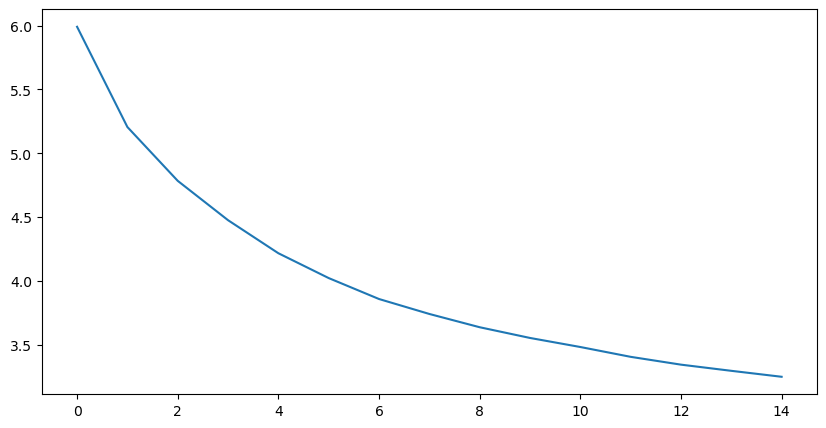

In [ ]:
blocks = [
    (64,   True,  False, True,  True),   # SE only
    (128,  True,  False, True,  True),
    (256,  True,  True,  True,  True),   # CBAM only here
    (320,  True,  False, True,  True),
]
def build_backbone():
    num_classes = len(cont_ds.base.label2idx)
    return ShroomCNNAttentive(in_ch=3, block_cfgs=blocks, mlp_units=[1024,512], num_classes=num_classes)



# run pretraining
enc_state_dict, feat_dim, proj_state_dict, hist = pretrain_contrastive(
    build_backbone, cont_loader,
    epochs=15, lr=1e-3, weight_decay=1e-4, temperature=0.07,
    use_hier=True, gamma=0.35,
    aux_lambda=0.1, aux_detach=False,
    species_to_genus=species_to_genus
)

print("Feature dim:", feat_dim)
plt.figure(figsize=(10,5))
plt.plot(hist, label='SupCon Loss')

Encoding (val):   0%|          | 0/61 [00:09<?, ?it/s]

[encoder f] shape=(15616, 320)  N=15616
t-SNE (encoder f) on 7638 points...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7638 samples in 0.000s...
[t-SNE] Computed neighbors for 7638 samples in 0.140s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7638
[t-SNE] Computed conditional probabilities for sample 2000 / 7638
[t-SNE] Computed conditional probabilities for sample 3000 / 7638
[t-SNE] Computed conditional probabilities for sample 4000 / 7638
[t-SNE] Computed conditional probabilities for sample 5000 / 7638
[t-SNE] Computed conditional probabilities for sample 6000 / 7638
[t-SNE] Computed conditional probabilities for sample 7000 / 7638
[t-SNE] Computed conditional probabilities for sample 7638 / 7638
[t-SNE] Mean sigma: 2.413691
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.922745
[t-SNE] KL divergence after 1000 iterations: 1.319540


/Users/TommyLubomirski/anaconda3/envs/cpsc330/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/jj/t84dzw752ynb90ssgn0q9d4w0000gp/T/ipykernel_9510/212524498.py:135: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')


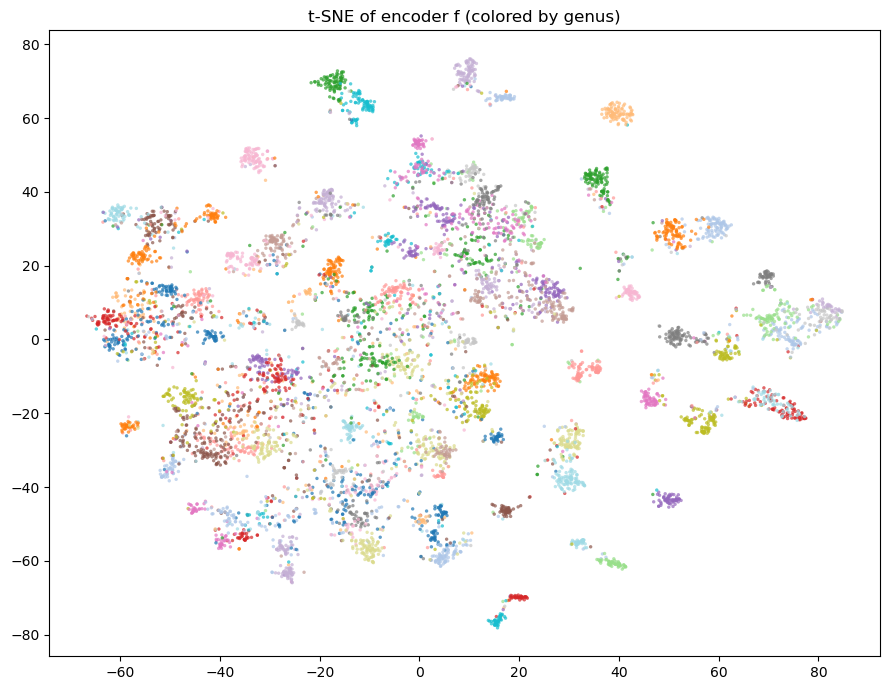

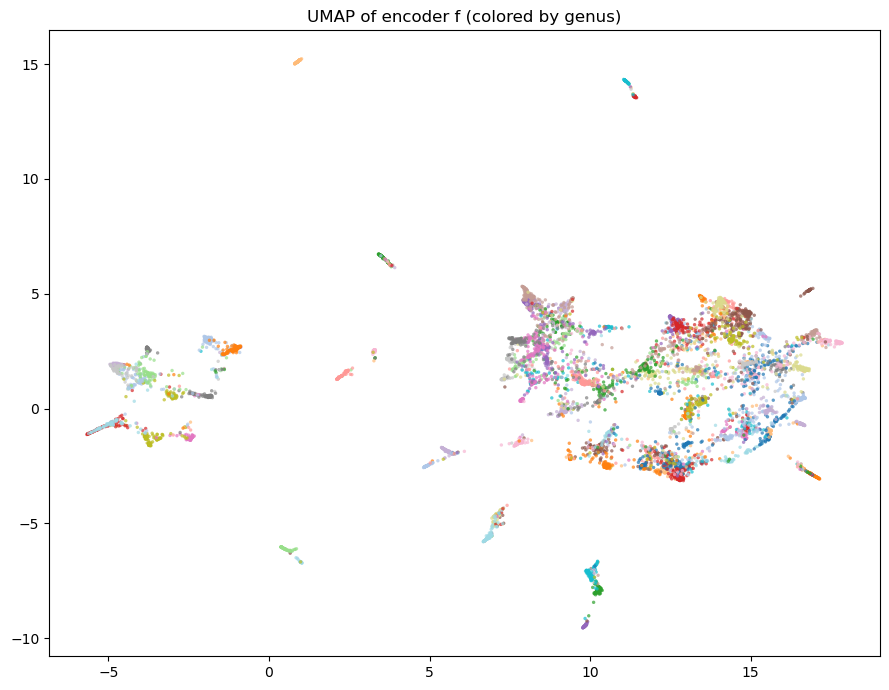

k-NN purity (k=10) on encoder f: species=0.573, genus=0.647


In [ ]:
# Embed & visualize after pretrain_contrastive 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from torchvision.transforms import v2 as T
from torch.utils.data import DataLoader

# Rebuild the encoder for inference
device = get_device()

backbone = build_backbone()
enc_infer = EncoderFromBackbone(backbone)
enc_infer.load_state_dict(enc_state_dict, strict=True)
enc_infer.eval().to(device)
try:
    enc_infer = enc_infer.to(memory_format=torch.channels_last)
except Exception:
    pass
for p in enc_infer.parameters():
    p.requires_grad = False

USE_PROJECTOR = False  # set False to skip
if USE_PROJECTOR:
    projector_infer = ProjectionMLP(feat_dim).to(device).eval()
    projector_infer.load_state_dict(proj_state_dict, strict=True)
    projector_infer.apply(_bn_to_fp32)
else:
    projector_infer = None

# 2) deterministic eval transform (center crop), same size as pretrain crop
EVAL_SIZE = IMGc if "IMGc" in globals() else 196
mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)
eval_tf = T.Compose([
    T.Resize(EVAL_SIZE, antialias=True),
    T.CenterCrop(EVAL_SIZE),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean, std),
])

# build a dataset/loader (use val set for speed/cleanliness)
# use the same label2idx as pretrain to keep species ids aligned.
eval_ds = ShroomDataset(val_meta, data_path, transform=eval_tf, label2idx=cont_base.label2idx)
NUM_WORKERS_EVAL = min(8, max(1, (os.cpu_count() or 4) // 2))
eval_loader = DataLoader(
    eval_ds, batch_size=256, shuffle=False,
    num_workers=NUM_WORKERS_EVAL, persistent_workers=(NUM_WORKERS_EVAL > 0),
    pin_memory=torch.cuda.is_available()
)

# collect BOTH encoder f and projector z in one pass 
feat_enc_list, feat_proj_list = [], []
species_ids_list = []

with torch.no_grad():
    for x, y in tqdm(eval_loader, desc="Encoding (val)", leave=False):
        x = x.to(device, non_blocking=True).contiguous(memory_format=torch.channels_last)
        f = enc_infer(x)                          # [B, feat_dim]
        f = torch.nan_to_num(f, nan=0.0).float()
        feat_enc_list.append(f.cpu())
        species_ids_list.append(y)

        if projector_infer is not None:
            z = projector_infer(f)                # normalized by ProjectionMLP (if BN present)
            feat_proj_list.append(z.cpu())

# Stack arrays
emb_enc = torch.cat(feat_enc_list, dim=0).numpy()                         # [N, Df]
species_ids = torch.cat(species_ids_list, dim=0).numpy().astype(np.int64) # [N]
genus_ids = np.asarray([int(species_to_genus[s]) for s in species_ids], dtype=np.int64)

emb_proj = None
if projector_infer is not None and len(feat_proj_list) > 0:
    emb_proj = torch.cat(feat_proj_list, dim=0).numpy()                    # [N, Dz]

print(f"[encoder f] shape={emb_enc.shape}  N={emb_enc.shape[0]}")
if emb_proj is not None:
    print(f"[projector z] shape={emb_proj.shape}  N={emb_proj.shape[0]}")

# reduce, plot, and compute k-NN purity for any embedding
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from inspect import signature

def reduce_plot_knn(emb, species_ids, genus_ids, name="embedding", max_tsne=10000):
    N, D = emb.shape
    # PCA to 50 dims
    MAX_PCA = min(50000, N)
    pca_idx = np.random.default_rng(0).choice(N, size=MAX_PCA, replace=False)
    pca = PCA(n_components=min(50, D), random_state=0)
    pca.fit(emb[pca_idx])
    X50 = pca.transform(emb)

    # stratified subsample for t-SNE
    if N > max_tsne:
        per_g = max(1, max_tsne // (genus_ids.max() + 1))
        idx_tsne = []
        rng = np.random.default_rng(1)
        for g in np.unique(genus_ids):
            g_idx = np.where(genus_ids == g)[0]
            take = min(len(g_idx), per_g)
            if take > 0:
                idx_tsne.append(rng.choice(g_idx, size=take, replace=False))
        idx_tsne = np.concatenate(idx_tsne) if len(idx_tsne) else np.arange(min(N, max_tsne))
    else:
        idx_tsne = np.arange(N)

    X50_sub = X50[idx_tsne]
    genus_sub = genus_ids[idx_tsne]


    _tsne_kwargs = dict(n_components=2, init="pca", perplexity=30, random_state=0)
    sig = signature(TSNE.__init__)
    supp = set(sig.parameters.keys())
    if "learning_rate" in supp: _tsne_kwargs["learning_rate"] = "auto"
    if "n_iter" in supp:        _tsne_kwargs["n_iter"] = 1000
    if "verbose" in supp:       _tsne_kwargs["verbose"] = 1

    print(f"t-SNE ({name}) on {len(idx_tsne)} points...")
    XY = TSNE(**_tsne_kwargs).fit_transform(X50_sub)

    # UMAP if available
    HAVE_UMAP = False
    try:
        import umap.umap_ as umap
        XY_umap = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=0).fit_transform(X50_sub)
        HAVE_UMAP = True
    except Exception:
        pass

    # plots
    cmap = plt.cm.get_cmap('tab20')
    colors = [cmap((g % 20) / 20.0) for g in genus_sub]

    plt.figure(figsize=(9,7))
    plt.scatter(XY[:,0], XY[:,1], c=colors, s=6, alpha=0.7, linewidths=0)
    plt.title(f"t-SNE of {name} (colored by genus)")
    plt.tight_layout(); plt.show()

    if HAVE_UMAP:
        plt.figure(figsize=(9,7))
        plt.scatter(XY_umap[:,0], XY_umap[:,1], c=colors, s=6, alpha=0.7, linewidths=0)
        plt.title(f"UMAP of {name} (colored by genus)")
        plt.tight_layout(); plt.show()

    # k-NN purity
    k = 10
    nn = NearestNeighbors(n_neighbors=k+1, algorithm="auto", n_jobs=-1)
    nn.fit(emb)
    _, nbrs = nn.kneighbors(emb, return_distance=True)
    nbrs = nbrs[:,1:]  # drop self
    sp_match = (species_ids[nbrs] == species_ids[:,None]).mean()
    gn_match = (genus_ids[nbrs]   == genus_ids[:,None]).mean()
    print(f"k-NN purity (k={k}) on {name}: species={sp_match:.3f}, genus={gn_match:.3f}")

# Run for encoder f
reduce_plot_knn(emb_enc, species_ids, genus_ids, name="encoder f")

# Run for projector z (if present)
if emb_proj is not None:
    reduce_plot_knn(emb_proj, species_ids, genus_ids, name="projector z")

In [ ]:
def one_nn_accuracy(emb, labels):
    nn = NearestNeighbors(n_neighbors=2, algorithm="auto", n_jobs=-1)  # self + 1 neighbor
    nn.fit(emb)
    _, nbrs = nn.kneighbors(emb, return_distance=True)
    pred = labels[nbrs[:,1]]  # neighbor label
    acc = (pred == labels).mean()
    return float(acc)

print("1-NN (encoder f) species acc:", f"{one_nn_accuracy(emb_enc, species_ids):.3f}")
if emb_proj is not None:
    print("1-NN (projector z) species acc:", f"{one_nn_accuracy(emb_proj, species_ids):.3f}")

import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from collections import defaultdict

def l2_normalize(a, eps=1e-8):
    n = np.linalg.norm(a, axis=1, keepdims=True)
    return a / np.clip(n, eps, None)

def knn_purity(emb, y_sp, y_gn, k=10, metric='cosine'):
    nn = NearestNeighbors(n_neighbors=k+1, metric=metric, algorithm='auto', n_jobs=-1)
    nn.fit(emb)
    _, nbrs = nn.kneighbors(emb, return_distance=True)  # includes self
    nbrs = nbrs[:,1:]  # drop self
    sp_match = (y_sp[nbrs] == y_sp[:,None]).mean()
    gn_match = (y_gn[nbrs] == y_gn[:,None]).mean()
    return float(sp_match), float(gn_match)

def one_nn_acc(emb, y_sp, metric='cosine'):
    nn = NearestNeighbors(n_neighbors=2, metric=metric, algorithm='auto', n_jobs=-1)
    nn.fit(emb)
    _, nbrs = nn.kneighbors(emb, return_distance=True)
    pred = y_sp[nbrs[:,1]]
    top1 = (pred == y_sp).mean()
    return float(top1), pred

def nearest_class_mean(emb, y_sp, y_gn, normalize=True):
    # compute centroids per species; predict by nearest centroid (cosine)
    X = l2_normalize(emb) if normalize else emb
    centroids = {}
    for sp in np.unique(y_sp):
        centroids[sp] = X[y_sp == sp].mean(axis=0)
        if normalize:
            c = centroids[sp]
            centroids[sp] = c / (np.linalg.norm(c) + 1e-8)
    C = np.stack([centroids[sp] for sp in sorted(centroids.keys())], axis=0)
    species_list = np.array(sorted(centroids.keys()), dtype=np.int64)

    # cosine sim -> argmax
    Xn = l2_normalize(X) if not normalize else X
    sims = Xn @ C.T
    pred_sp = species_list[np.argmax(sims, axis=1)]

    # species acc
    sp_acc = (pred_sp == y_sp).mean()

    # genus acc (from predicted species)
    pred_gn = np.asarray([int(species_to_genus[s]) for s in pred_sp], dtype=np.int64)
    gn_acc = (pred_gn == y_gn).mean()
    return float(sp_acc), float(gn_acc)

def report_all(name, emb, y_sp, y_gn, do_pca_whiten=True):
    print(f"\n=== {name} ({emb.shape[0]}×{emb.shape[1]}) ===")

    # unnormalized & L2-normalized views
    emb_l2 = l2_normalize(emb)

    for metric in ['cosine', 'euclidean']:
        t1, _ = one_nn_acc(emb_l2 if metric=='euclidean' else emb, y_sp, metric=metric)
        sp5, gn5  = knn_purity(emb_l2 if metric=='euclidean' else emb, y_sp, y_gn, k=5,  metric=metric)
        sp10, gn10= knn_purity(emb_l2 if metric=='euclidean' else emb, y_sp, y_gn, k=10, metric=metric)
        print(f"[{metric}] 1-NN species={t1:.3f} | k=5: sp={sp5:.3f}, gn={gn5:.3f} | k=10: sp={sp10:.3f}, gn={gn10:.3f}")

    # PCA-whiten -> Euclidean (common trick for k-NN on embeddings)
    if do_pca_whiten:
        d = min(128, emb.shape[1])  # 64/128 are typical
        pca = PCA(n_components=d, whiten=True, random_state=0)
        Xw  = pca.fit_transform(emb)
        t1w,_ = one_nn_acc(Xw, y_sp, metric='euclidean')
        sp5w, gn5w   = knn_purity(Xw, y_sp, y_gn, k=5,  metric='euclidean')
        sp10w, gn10w = knn_purity(Xw, y_sp, y_gn, k=10, metric='euclidean')
        print(f"[PCA{d}-whiten+euclid] 1-NN species={t1w:.3f} | k=5: sp={sp5w:.3f}, gn={gn5w:.3f} | k=10: sp={sp10w:.3f}, gn={gn10w:.3f}")

    # Nearest-class-mean (cosine)
    sp_acc, gn_acc = nearest_class_mean(emb, y_sp, y_gn, normalize=True)
    print(f"[NCM cosine] species={sp_acc:.3f} | genus={gn_acc:.3f}")

# Run for encoder f
report_all("encoder f", emb_enc, species_ids, genus_ids)

# Run for projector z (if available)
if emb_proj is not None:
    report_all("projector z", emb_proj, species_ids, genus_ids)

1-NN (encoder f) species acc: 0.612

=== encoder f (15616×320) ===
[cosine] 1-NN species=0.623 | k=5: sp=0.600, gn=0.671 | k=10: sp=0.585, gn=0.659
[euclidean] 1-NN species=0.623 | k=5: sp=0.600, gn=0.671 | k=10: sp=0.585, gn=0.659
[PCA128-whiten+euclid] 1-NN species=0.594 | k=5: sp=0.567, gn=0.632 | k=10: sp=0.547, gn=0.612
[NCM cosine] species=0.653 | genus=0.715
